In [1]:
# notebook to elucidate the secrets of the simple reactor solver
# (and maybe compare results to Cantera)

In [205]:
import rmgpy.chemkin
import os

import cantera as ct
import numpy as np
import logging

import rmgpy.solver  # import SimpleReactor, TerminationTime, SurfaceReactor
import rmgpy.quantity  #import Quantity
import rmgpy.rmg.listener # import SimulationProfileWriter, SimulationProfilePlotter
import rmgpy.rmg.settings  #import ModelSettings, SimulatorSettings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.DEBUG)



DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [231]:
sevy_mech = '/home/moon/rmg/RMG-Py/examples/rmg/superminimal/chemkin'
s_chemkin = os.path.join(sevy_mech, 'chem_annotated.inp')
s_dict = os.path.join(sevy_mech, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(s_chemkin, s_dict)

output_directory = 'simple_csvs'

os.makedirs(output_directory, exist_ok=True)

INFO:root:Thermo file has default temperature range 300.0 to 1000.0 and 1000.0 to 5000.0


# Cantera version

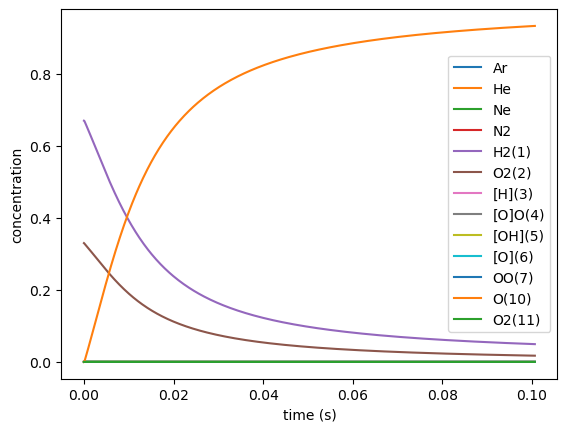

In [244]:
gas = ct.Solution('/home/moon/rmg/RMG-Py/examples/rmg/superminimal/cantera/chem_annotated.yaml')

T = 1500.0
P = 100000.0
initial_mole_fractions='H2(1):0.67, O2(2):0.33'
gas.TPX = T, P, initial_mole_fractions

# reactor = ct.IdealGasReactor(gas)
reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # isothermal
net = ct.ReactorNet([reactor])
ts_ct = [net.time]
ys_ct = [reactor.thermo.X]
while net.time < 1e-1:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(reactor.thermo.X)

# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

# RMG simple.pyx

In [245]:
T = (1500, 'K')
P = (1, 'bar')
termination_time = (1.0e-1, 's')
termination = [rmgpy.solver.TerminationTime(rmgpy.quantity.Quantity(termination_time))]
sensitivity_threshold=1e-3

# display(species_list[4], species_list[5])
initial_mole_fractions={
    species_list[4]: 0.67,  # H2
    species_list[5]: 0.33,  # O2
}
sensitive_species = [species_list[4]]
sensitive_species = []


reaction_system = rmgpy.solver.SimpleReactor(
    T=T,
    P=P,
    initial_mole_fractions=initial_mole_fractions,
    termination=termination,
    sensitive_species=sensitive_species,
    sensitivity_threshold=sensitivity_threshold
)


reaction_system.initialize_model(
    species_list,
    reaction_list,
    [],
    [],
)

DEBUG:root:Initializing surface...
DEBUG:root:Surface initialization complete


In [246]:

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
time_step = 10 ** 0.05  # The multiplicative factor to use between consecutive time points
abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

terminated = False
next_time = initial_time
step_time = initial_time

times = [reaction_system.t]
# ys = [reaction_system.y]
ys = [reaction_system.core_species_concentrations]

while reaction_system.t < termination_time[0]:
    # Integrate forward in time to the next time point
    reaction_system.step(step_time)

    if reaction_system.t >= 0.9999 * next_time:
        next_time *= time_step
        times.append(reaction_system.t)
        ys.append(reaction_system.core_species_concentrations)
#         ys.append(reaction_system.y)

    # Increment destination step time if necessary
    if reaction_system.t >= 0.9999 * step_time:
        step_time *= 10.0

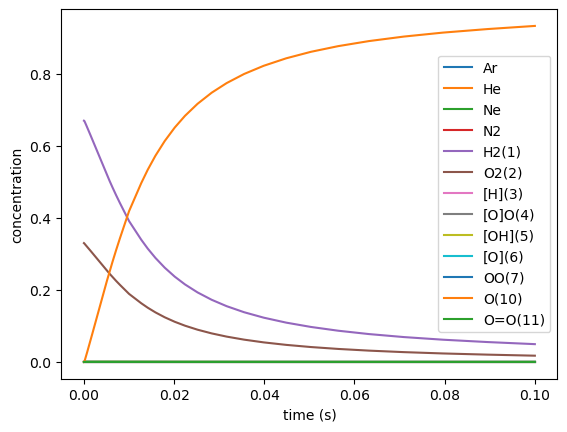

In [247]:
for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), label=str(species_list[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()

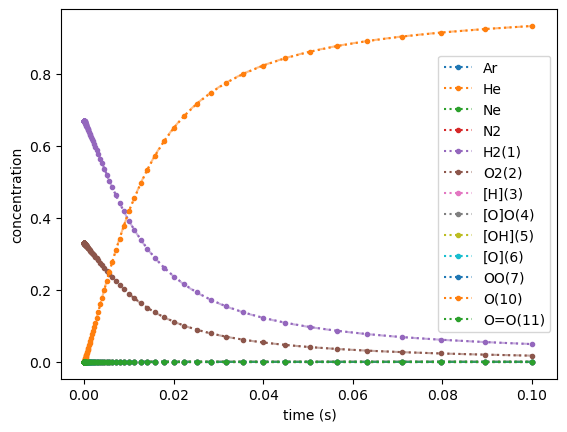

In [254]:
# plot on top of each other

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

assert len(ys[0]) == len(ys_ct[0])

for i in range(len(ys[0])):
    y_hs = [x[i] for x in ys]
    plt.plot(times, y_hs / np.sum(ys[0]), marker='.', color=colors[i % len(colors)], label=str(species_list[i]), linestyle='dotted')
    
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, color=colors[i % len(colors)], linestyle='dashed', alpha=0.5)
    
    
    
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend()